## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder
from typing import Dict, List, Union, Tuple
import datetime
from collections import Counter
from pathlib import Path
import sys

root = Path.cwd().parent

transformer_path = root / 'Data Processing'
path_Random_forest = root / 'Classification Models' / 'Uninterpretable Models'
path_Decision_tree = root / 'Classification Models' / 'Interpretable Models'
path_post_hoc = root / 'Model Explanations' / 'Post-Hoc Analysis'
path_inherent = root / 'Model Explanations' / 'Inherently Interpretable Analysis'

sys.path.append(str(transformer_path))
sys.path.append(str(path_Random_forest))
sys.path.append(str(path_Decision_tree))
sys.path.append(str(path_post_hoc))
sys.path.append(str(path_inherent))
sys.path.append(str(Path.cwd().parent))

from demo_distribution_plot import *
from synthetic_data_generator import *

import DataTransformer
import Randomforest
import SHAP_posthoc

c:\Users\makuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating the data

### Same distribution as real world

In [2]:
# https://usafacts.org/data/topics/people-society/population-and-demographics/our-changing-population/

real_world_distribution = {
    'sex': {
        'Male': 0.5,
        'Female': 0.5
    },
    'age_bin': {
        '18-25': 0.1,
        '26-45': 0.2,
        '46+': 0.3
    },
    'race': {
        'Other': 0.026,
        'Caucasian': 0.589,
        'African American': 0.126,
        'Hispanic': 0.191,
        'Asian': 0.061,
        'Native American': 0.007
    },
}

In [3]:
df = pd.read_csv("../Dataset/cox-violent-parsed_filt.csv")

df = df.dropna(subset=["score_text"])

# Preprocessing: Replace 'African-American' with 'African American' in the 'race' column
df['race'] = df['race'].str.replace('African-American', 'African American')

# Define relevant columns and target
relevant = ["sex","age","race","juv_fel_count","juv_misd_count","juv_other_count",
            "c_charge_degree","r_charge_degree","r_days_from_arrest","vr_charge_degree"]
target = "score_text"

# Define columns to One-Hot Encode
one_hot_columns = ['race', 'sex']

df.head()

,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
2,3.0,michael ryan,michael,ryan,Male,06/02/1985,31,25 - 45,Caucasian,0,...,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,0,0
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African American,0,...,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African American,0,...,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0


In [ ]:
new_df = resample_with_smotenc(df[relevant + ['score_text']], real_world_distribution)

y = new_df[target]

Achieved proportions:

sex:
  Male: 0.74
  Female: 0.26

age_bin:
  26-45: 0.46
  46+: 0.30
  18-25: 0.24

race:
  African American: 0.47
  Caucasian: 0.36
  Hispanic: 0.10
  Other: 0.04
  Asian: 0.02
  Native American: 0.00
Final achieved proportions:

sex:
  Female: 0.50
  Male: 0.50

Discrepancy from target:
  Male: Target 0.50 vs Achieved 0.50, Diff: 0.0000
  Female: Target 0.50 vs Achieved 0.50, Diff: 0.0000

age_bin:
  26-45: 0.46
  46+: 0.30
  18-25: 0.24

Discrepancy from target:
  18-25: Target 0.10 vs Achieved 0.24, Diff: 0.1425
  26-45: Target 0.20 vs Achieved 0.46, Diff: 0.2575
  46+: Target 0.30 vs Achieved 0.30, Diff: 0.0000

race:
  Caucasian: 0.59
  Hispanic: 0.19
  African American: 0.13
  Asian: 0.06
  Other: 0.03
  Native American: 0.01

Discrepancy from target:
  Other: Target 0.03 vs Achieved 0.03, Diff: -0.0000
  Caucasian: Target 0.59 vs Achieved 0.59, Diff: -0.0000
  African American: Target 0.13 vs Achieved 0.13, Diff: 0.0001
  Hispanic: Target 0.19 vs Achieved

In [5]:
processor = DataTransformer.DataTransformer(
    df=new_df,
    y=y,
    relevant_columns=relevant,
    onehot_cols=one_hot_columns,
)

processor.fit_pipeline()
X_train, X_test, y_train, y_test = processor.split_data()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17040, 16), (4260, 16), (17040,), (4260,))

## Training the models

### Decision Tree

Evaluation metrics saved to 'evaluation_results/evaluation_DecisionTreeClassifier.txt'


FileNotFoundError: [Errno 2] No such file or directory: 'Classification Models/Evaluation Results/confusion_matrix_DecisionTreeClassifier.png'

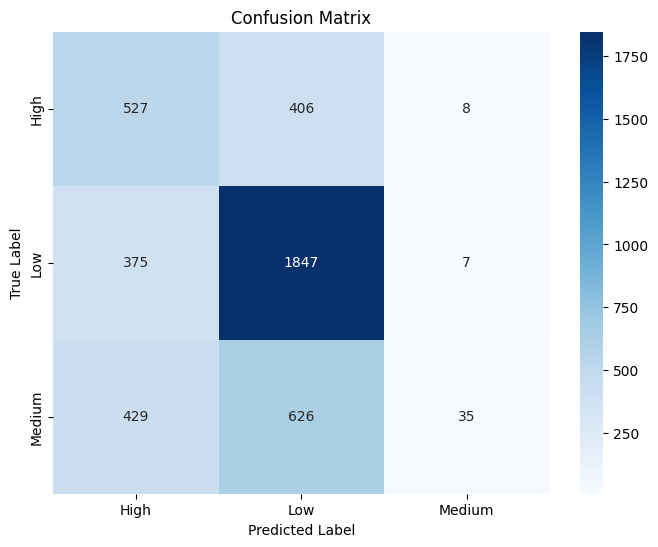

In [8]:
import DecisionTree

dt = DecisionTree.DecisionTreeTrainer(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    model_path="Saved Models/White Mirror Real World Distribution/decision_tree_model.pkl"
)

dt.train_decision_tree()
trained_dt = dt.get_model()
dt.evaluate_decision_tree()
# dt.save_decision_tree()

### EBM

c:\Users\makuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1165: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
c:\Users\makuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1165: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
c:\Users\m

Evaluation metrics saved to 'evaluation_results/evaluation_ExplainableBoostingClassifier.txt'


FileNotFoundError: [Errno 2] No such file or directory: 'Classification Models/Evaluation Results/confusion_matrix_ExplainableBoostingClassifier.png'

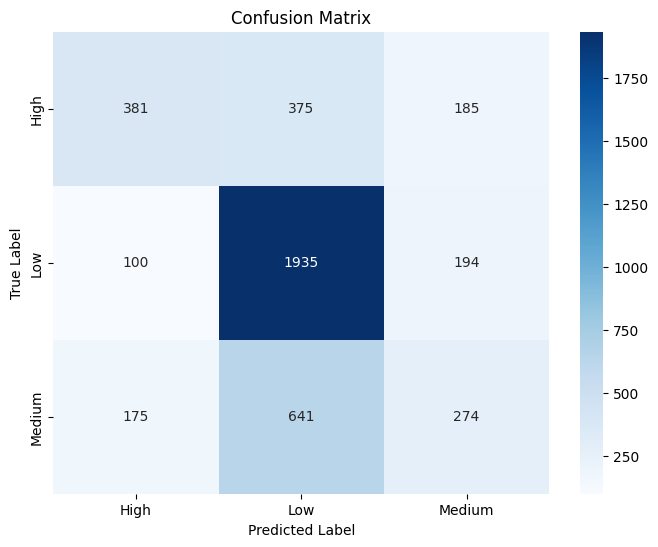

In [9]:
# explainable boosting machine
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
import Explainable_Boosting_Machines

ebm = Explainable_Boosting_Machines.ExplainableBoostingTrainer(
    X_train, y_train, X_test, y_test, 
    processor.get_feature_names(), 
    model_path="Saved Models/White Mirror Real World Distribution/ebm_model.pkl")

ebm.train_ebm()
trained_ebm = ebm.get_model()
ebm.evaluate_ebm()

# ebm.save_ebm()

### Random Forest

Evaluation metrics saved to 'evaluation_results/evaluation_RandomForestClassifier.txt'


FileNotFoundError: [Errno 2] No such file or directory: 'Classification Models/Evaluation Results/confusion_matrix_RandomForestClassifier.png'

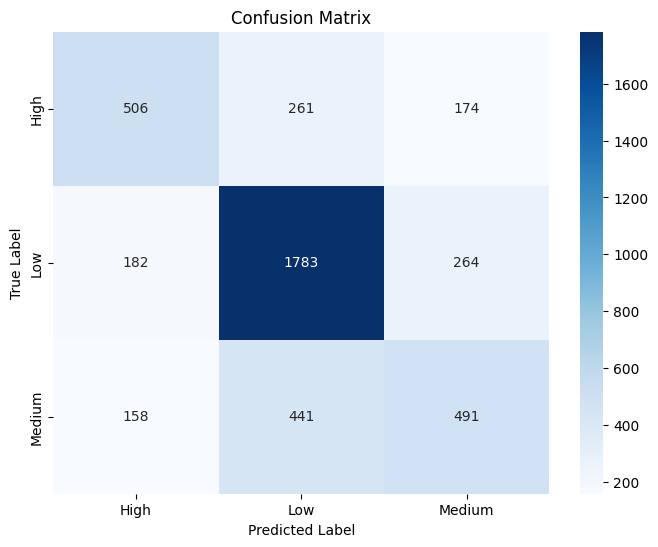

In [10]:
import Randomforest

rf = Randomforest.RandomForestTrainer(
    X_train,
    y_train,
    X_test,
    y_test,
    model_path="Saved Models/White Mirror Real World Distribution/random_forest_model.pkl",
)

rf.train_random_forest()
trained_rf = rf.get_model()
# rf.save_random_forest()
rf.evaluate_random_forest()

### Neural Network

In [21]:
import MLPClassifier

nn = MLPClassifier.NeuralNetworkTrainer(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    model_path="Saved Models/White Mirror Real World Distribution/neural_network_model.pkl")

nn.train_neural_network()
# nn.evaluate_neural_network()
trained_nn = nn.get_model()
nn.save_neural_network()

Model saved successfully to Saved Models/White Mirror Real World Distribution/neural_network_model.pkl.


## Explanations

### EBM

In [12]:
trained_ebm = ebm.get_model()

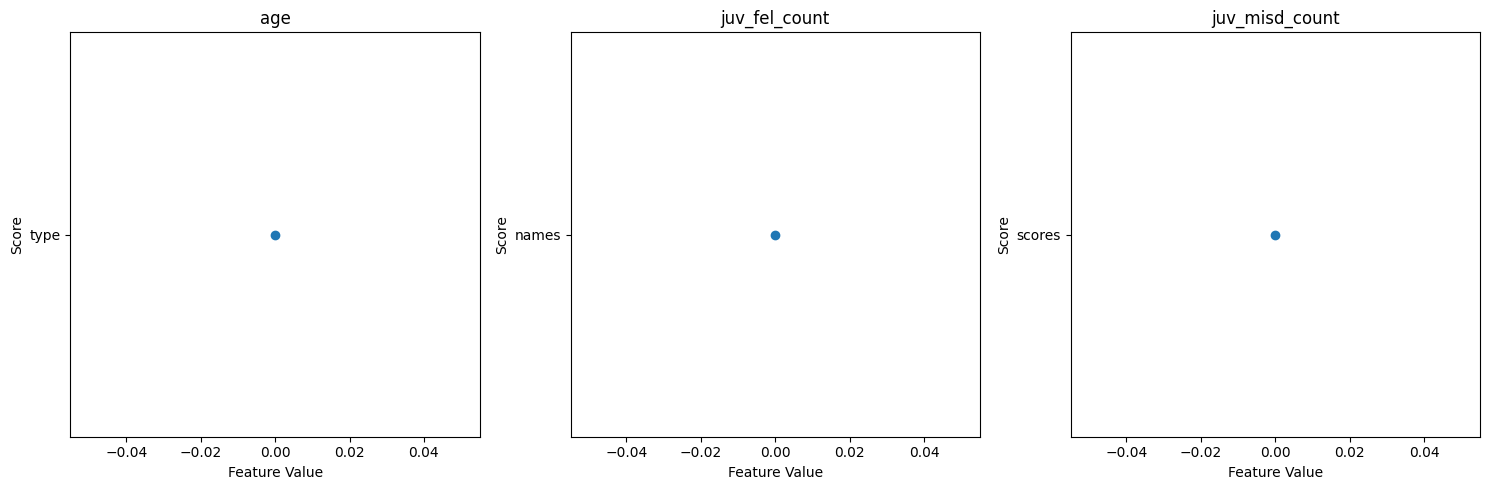

Feature importances structure: {'type': 'univariate', 'names': ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'r_days_from_arrest', 'race_African American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'sex_Female', 'sex_Male', 'c_charge_degree', 'r_charge_degree', 'vr_charge_degree'], 'scores': [np.float64(0.35468460731303264), np.float64(0.07478422957324182), np.float64(0.06674258269222665), np.float64(0.044367682139631326), np.float64(0.06499601476658), np.float64(0.043133448535739916), np.float64(0.003148557673555907), np.float64(0.015179244754244979), np.float64(0.016590708247169923), np.float64(0.0018360384189642725), np.float64(0.03328572466712642), np.float64(0.010035413628295279), np.float64(0.01008645975729901), np.float64(0.15923271416092533), np.float64(0.18724313631646158), np.float64(0.01783018759123105)]}


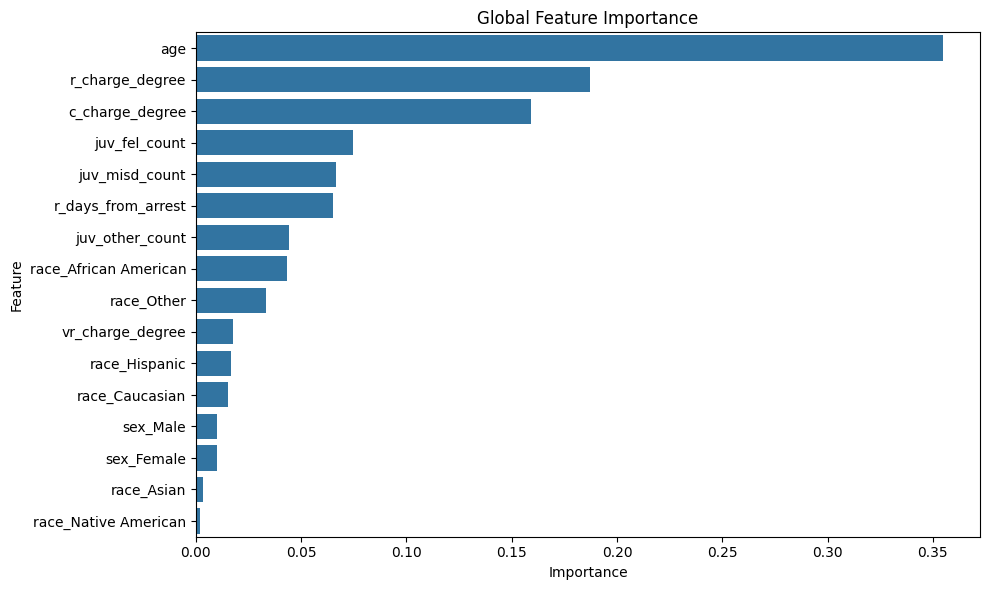

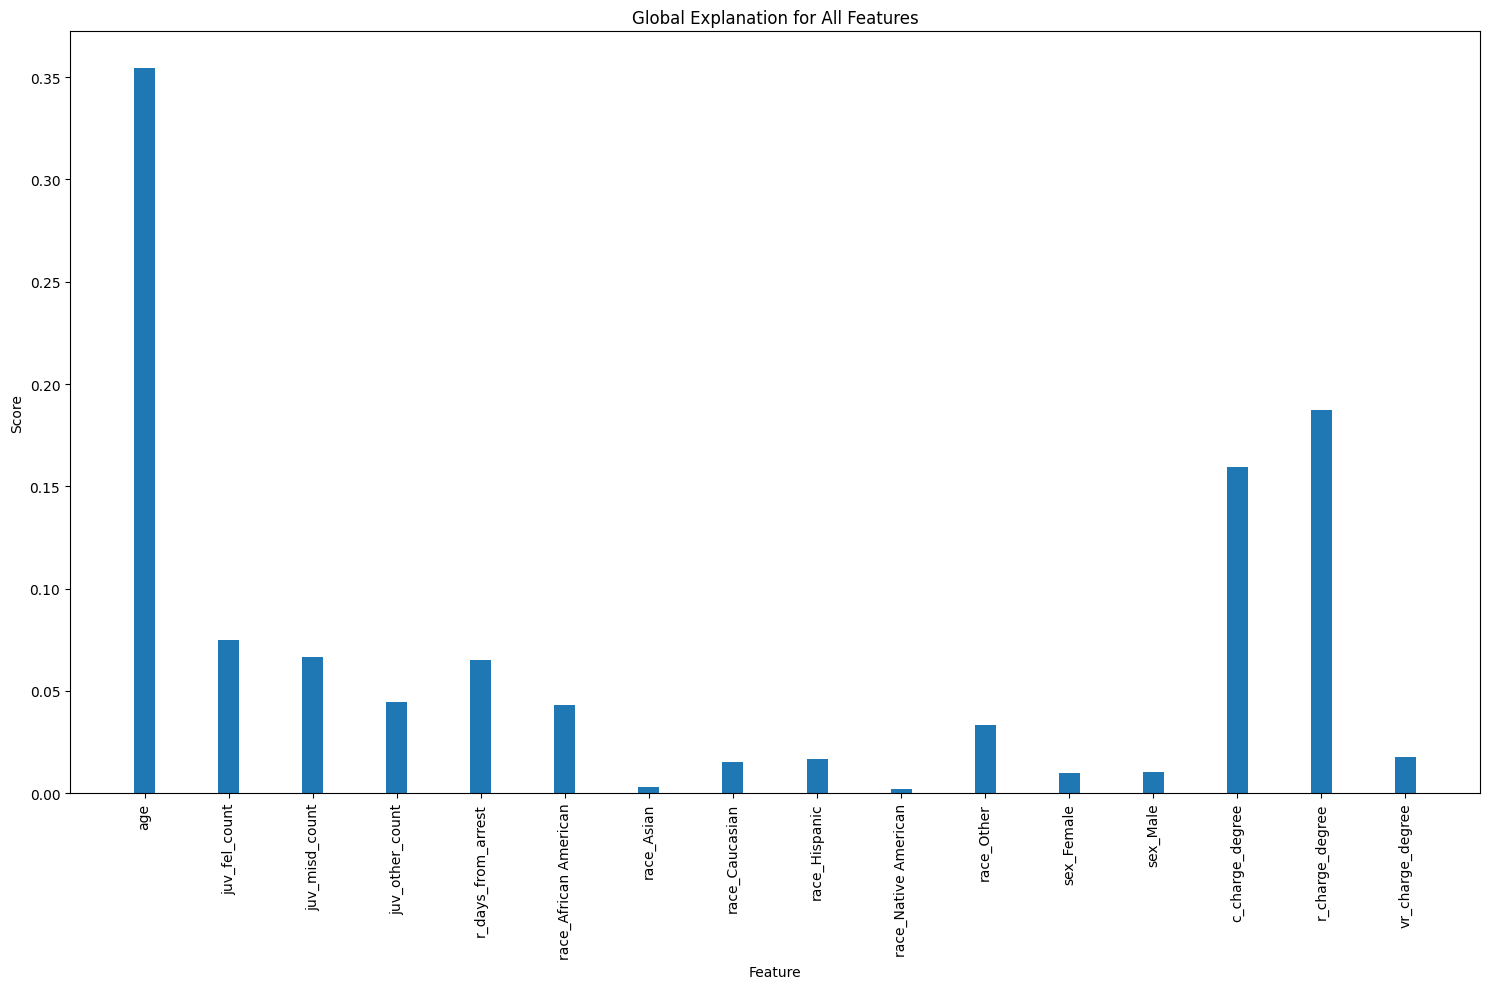

['Low', 'Medium', 'High']


In [13]:
import Vizualize_ebm

ebm.global_explanation()

ebm_global = Vizualize_ebm.VizEBM(trained_ebm, X_train, X_test, y_test, processor.get_feature_names(), y.unique().tolist())
ebm_global.explain_global()

print(y.unique().tolist())

Using 426 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


TreeExplainer not supported, switching to DeepExplainer: Model type not yet supported by TreeExplainer: <class 'interpret.glassbox._ebm._ebm.ExplainableBoostingClassifier'>
DeepExplainer also failed, switching to KernelExplainer: No module named 'tensorflow'
(426, 16)


  0%|          | 0/426 [00:00<?, ?it/s]

100%|██████████| 426/426 [15:23<00:00,  2.17s/it]
c:\Users\makuz\VS Code Projects\AI_Decoded\Model Explanations\Post-Hoc Analysis\SHAP_posthoc.py:93: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



SHAP values shape: (426, 16, 3)
X_subset shape: (426, 16)
shap_values_total shape =  (426, 16)


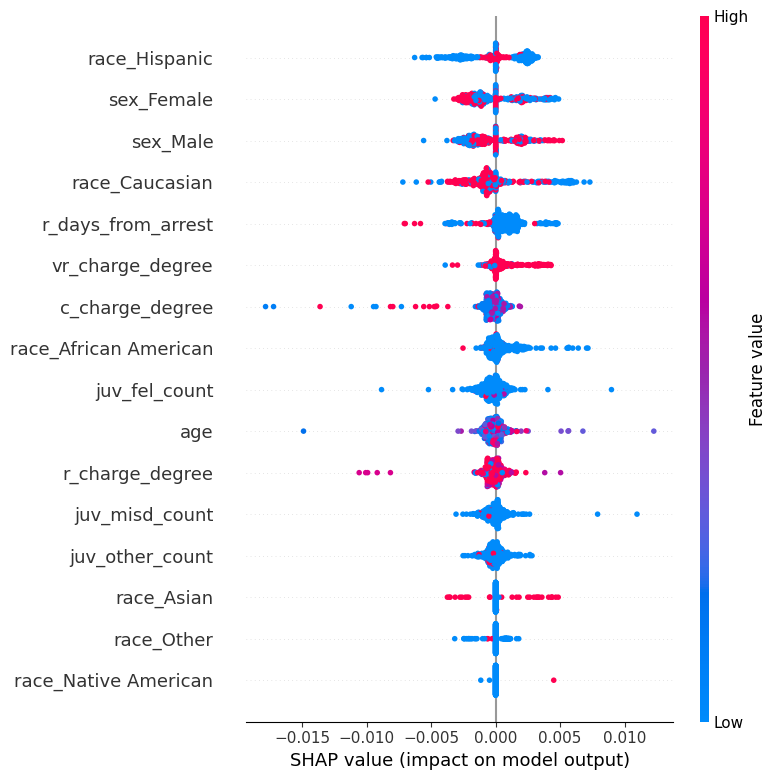

c:\Users\makuz\VS Code Projects\AI_Decoded\Model Explanations\Post-Hoc Analysis\SHAP_posthoc.py:100: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



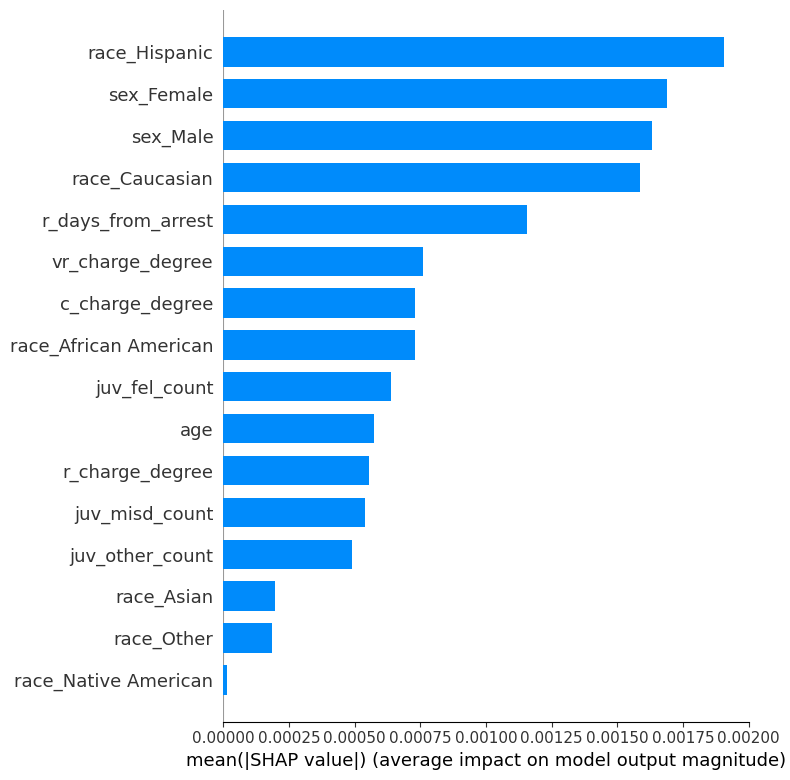

SHAP general explanation generated successfully.


In [18]:
shap_ebm = SHAP_posthoc.SHAPAnalysis(trained_ebm, X_train, X_test, y_test, processor.get_feature_names(), "Explainable Boosted Machine")
shap_ebm.perform_shap_general_explanation()

### Decision Tree

SHAP values shape: (426, 16, 3)
X_subset shape: (426, 16)
shap_values_total shape =  (426, 16)


c:\Users\makuz\VS Code Projects\AI_Decoded\Model Explanations\Post-Hoc Analysis\SHAP_posthoc.py:93: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



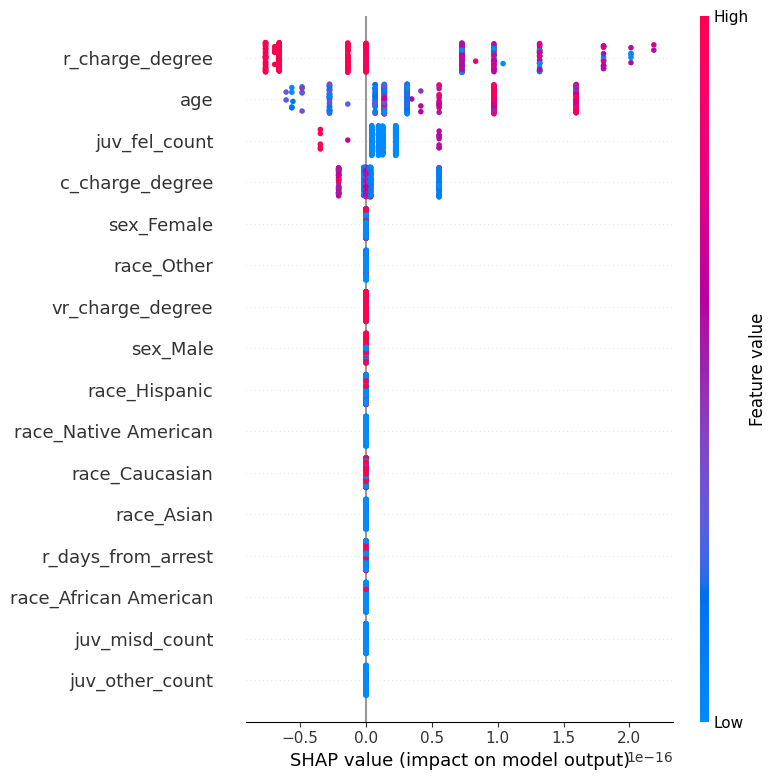

c:\Users\makuz\VS Code Projects\AI_Decoded\Model Explanations\Post-Hoc Analysis\SHAP_posthoc.py:100: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



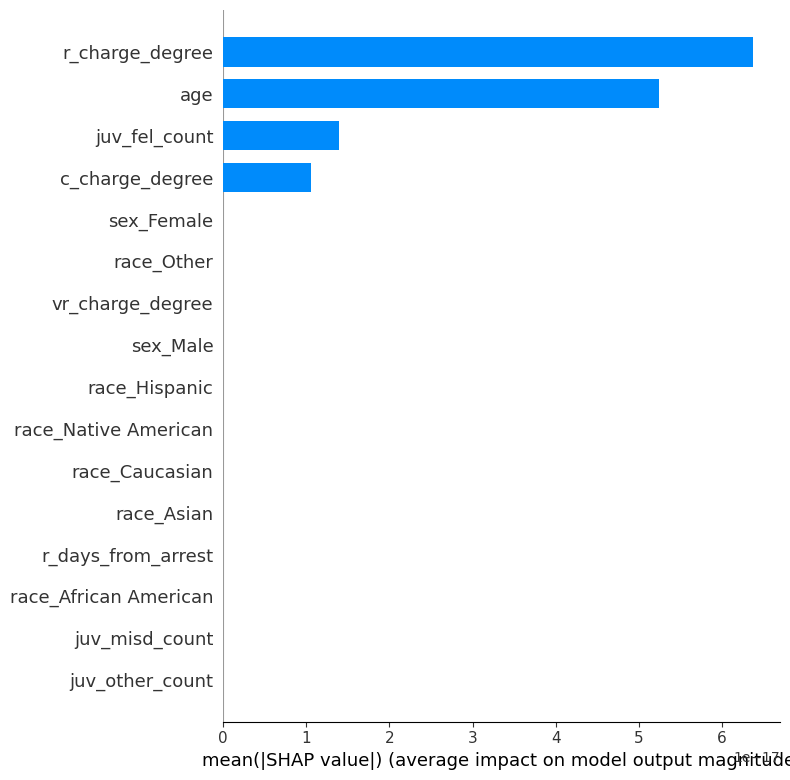

SHAP general explanation generated successfully.


In [14]:
shap_dt = SHAP_posthoc.SHAPAnalysis(trained_dt, X_train, X_test, y_test, processor.get_feature_names(), "Decision Tree")
shap_dt.perform_shap_general_explanation()

### Random Forest

SHAP values shape: (426, 16, 3)
X_subset shape: (426, 16)
shap_values_total shape =  (426, 16)


c:\Users\makuz\VS Code Projects\AI_Decoded\Model Explanations\Post-Hoc Analysis\SHAP_posthoc.py:93: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



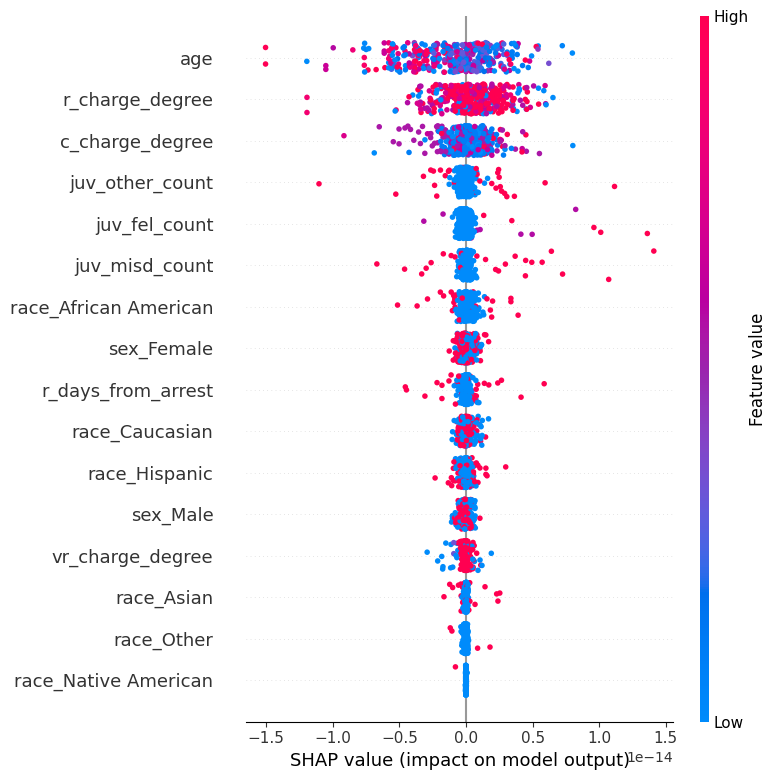

c:\Users\makuz\VS Code Projects\AI_Decoded\Model Explanations\Post-Hoc Analysis\SHAP_posthoc.py:100: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



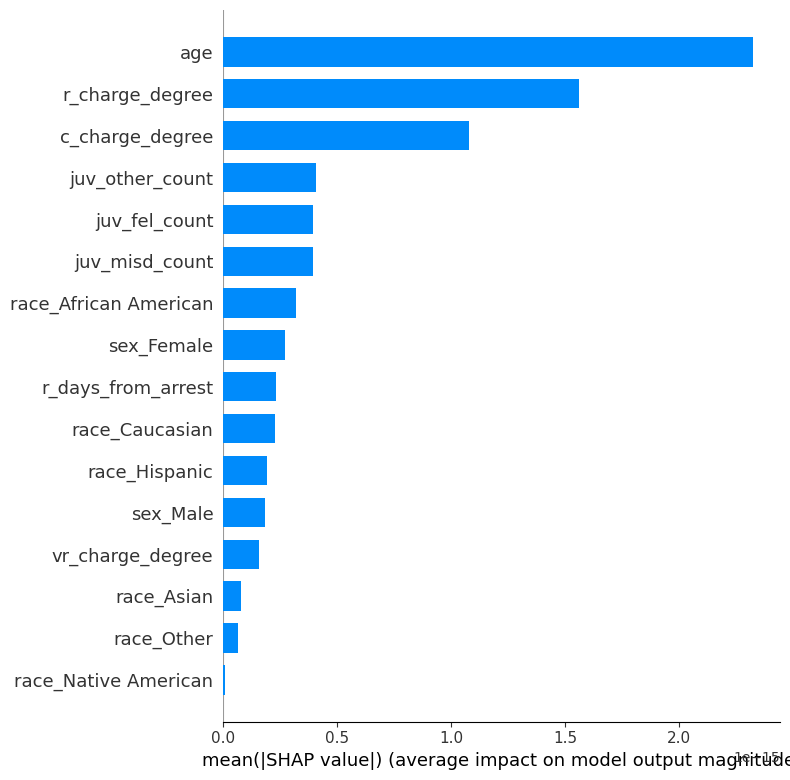

SHAP general explanation generated successfully.


In [20]:
shap_rf = SHAP_posthoc.SHAPAnalysis(
    trained_rf, X_train, X_test, y_test,
    processor.get_feature_names(), "RandomForest")
shap_rf.perform_shap_general_explanation() 

### Neural Network